In [1]:
from unet import *
import functions
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import math
from tqdm import trange
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from skimage.metrics import structural_similarity as ssim
import pandas as pd
import scipy.io
# tensor summary import
from torchsummary import summary

In [2]:
checkpoint = "checkpoints_private/2023_04_09_short_100_state.pt"
#checkpoint = "saved_models/model_epoch_30.pth"
#checkpoint = "checkpoints_private/2023_04_08.pt"
#checkpoint = "checkpoints_private/2023_04_09_extrashort.pt"
#checkpoint = "checkpoints_private/2023_04_09_short_100_state.pt"

Net = build_unet()
Net.load_state_dict(torch.load(checkpoint))

#Net.eval()
torch.no_grad()
# check if CUDA is available, and set it as the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("==> Device: {}".format(device))

# move model to the device
Net.to(device)

# define loss function
#loss_function = nn.MSELoss()
loss_function = nn.L1Loss()

####### HYPERPARAMETERS #######

# patch size
patch_size = 512

# batch size
batch_size = 1

# keep track of the best validation loss
valid_loss_min = np.Inf

##### LOSS  #######

# keep track of training and validation loss
test_loss = []
valid_loss = []

# initialize the early_stopping object
# early_stopping = EarlyStopping(patience=early_stopping, verbose=True)


==> Device: cuda


In [3]:
def calculatePSNR(img1, img2):
    img1 = np.array(img1)
    img2 = np.array(img2)
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

In [4]:
# read the list.txt as a space separated dataframe
df = pd.read_csv('Sony_test_list.csv', sep=',', header=None)
#df = pd.read_csv('list_extrashortkingdom.csv', sep=',', header=None)
#df = pd.read_csv('list_shortkingdom.csv', sep=',', header=None)
#df = pd.read_csv('list.csv', sep=',', header=None)

# split df into input, label columns
input_df = df.iloc[:, 0]
label_df = df.iloc[:, 1]

# create a list of tuples
image_label_list = list(zip(input_df, label_df))

# create a dataset object
dataset = Dataset()

# create a dataloader object
dataloader = DataLoader(image_label_list, batch_size=batch_size, shuffle=False)

print('number of images in dataset: {}'.format(len(dataloader)))

result_dir = "results_test/"
if not os.path.isdir(result_dir):
                os.makedirs(result_dir)

number of images in dataset: 598



Loss:   0%|          | 0/598 [00:37<?, ?it/s]

Loss: 100%|██████████| 598/598 [18:41<00:00,  1.88s/it]

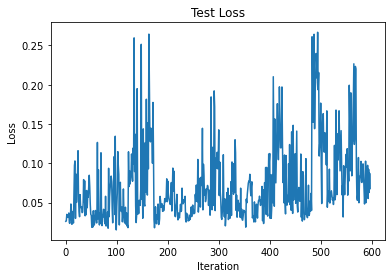

NameError: name 'SSIM' is not defined

In [6]:
epoch_loss = 0
cnt = 0

t = trange(len(dataloader), desc='Loss: ', leave=True)
t.reset()
#for epoch in t:

for input, label in dataloader:
    # load the first image and label
    # print(' ------------ new batch --------------')
    # print("Input: " + str(input))
    # print("Label: " + str(label))
    input = input[0]
    label = label[0]

    exposure_input = float(((input.split('_'))[-1]).rstrip('s.ARW'))
    exposure_label = float(((label.split('_'))[-1]).rstrip('s.ARW'))
    ratio = min(exposure_label / exposure_input, 300)

    # image = rawpy.imread(input)
    image = functions.pack_raw_sony(rawpy.imread(input)) * ratio
    # image = np.expand_dims(image, axis=0)
    label = rawpy.imread(label)

    # convert the image and label to numpy arrays
    # image = image.postprocess(use_camera_wb=True, half_size=False, no_auto_bright=True, output_bps=16)
    label = label.postprocess(use_camera_wb=True, half_size=False, no_auto_bright=True, output_bps=16)

    # convert the image and label to float32 data type
    # image = np.float32(image / 65535.0)
    label = np.float32(label / 65535.0)
    # label = np.expand_dims(label, axis=0)
    image = np.minimum(image, 1.0)
    ####### POSTPROCESSING #######

    # crop the image and label to 512 x 512
    image, label = functions.random_crop(image, label, patch_size)


    # convert the image and label to tensors
    image = torch.from_numpy(np.expand_dims(np.transpose(image, (2, 0, 1)), axis=0))
    label = torch.from_numpy(np.expand_dims(np.transpose(label, (2, 0, 1)), axis=0))

    # move the image and label to the device
    image, label = image.to(device), label.to(device)

    # forward pass
    output = Net(image)

    # calculate the loss
    loss = loss_function(output, label)



    # convert
    label_image = label[0].cpu().detach().numpy().transpose(1, 2, 0)
    output_image = output[0].cpu().detach().numpy().transpose(1, 2, 0)
    output_image = np.minimum(np.maximum(output_image, 0), 1)

    PSNR = calculatePSNR(output_image, label_image)
    SSIM = ssim(output_image, label_image, data_range=output_image.max() - output_image.min(), multichannel=True)

    if cnt % 1 == 0:
        label_image = label[0].cpu().detach().numpy().transpose(1, 2, 0)
        output_image = output[0].cpu().detach().numpy().transpose(1, 2, 0)
        output_image = np.minimum(np.maximum(output_image, 0), 1)
        output_image = np.concatenate((label_image, output_image), axis=1)

        if not os.path.isdir(result_dir):
            os.makedirs(result_dir)
        functions.toimage(output_image * 255, high=255, low=0, cmin=0, cmax=255).save(
            result_dir + '%05d_' % ratio + str(os.path.basename(input)[:-3]) + 'jpg')

    # append loss to the list
    test_loss.append(loss.item())

    cnt = cnt + 1
    t.update()


# plot loss
plt.plot(test_loss)
plt.title("Test Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

mean_psnr = np.mean(PSNR)
mean_ssim = np.mean(SSIM)
print("PSNR: " + str(mean_psnr))
print("SSIM: " + str(mean_ssim))

# plot


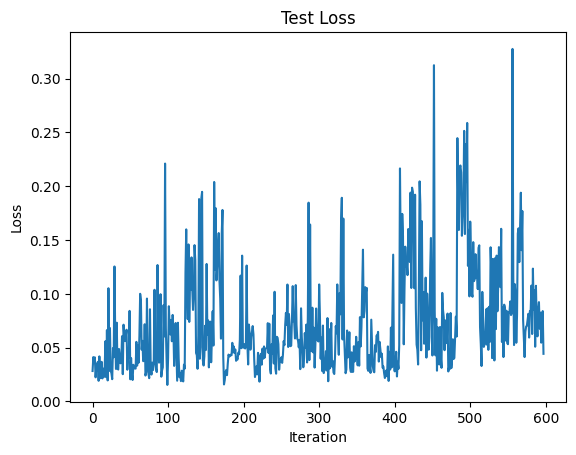

In [5]:
plt.plot(test_loss)
plt.title("Test Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()